In [9]:
# pairwise-t-test

models = ['gpt4.o', 'gpt4.omini', 'llama3_1_instruct_70b', 'llama3_8b', 'gemma2_9b', 'qwen2_7b']  #  'exaone_8b', 
model_renames = {
    'gpt4.o': 'GPT-4o',
    'gpt4.omini': 'GPT-4o-mini',
    'llama3_1_instruct_70b': 'Llama-3.1-70B',
    'llama3_8b': 'Llama-3.1-8B',
    'gemma2_9b': 'Gemma-2-9B',
    'exaone_8b': 'ExaOne-8B',
    'qwen2_7b': 'Qwen-2-7B'
}

from scipy.stats import ttest_rel  # ttest_ind 대신 ttest_rel 사용
from scipy import stats
import numpy as np

def compute_abs_diff_t_test(base, biased):
    """
    Compute one-sample t-test on absolute differences against null hypothesis (mean = 0)
    
    Args:
        base (list): List of continuous values from base condition
        biased (list): List of continuous values from biased condition
    
    Returns:
        tuple: (mean absolute difference, t-statistic, p-value)
    """
    differences = biased - base
    abs_differences = np.abs(differences)
    t_stat, p_value = stats.ttest_1samp(abs_differences, popmean=0)
    return p_value  # abs_differences.mean(), t_stat, 

# /data1/bumjin/room1805/deontic/results/experiment3/dataset5/base/binary/results_gpt4.o.csv

import pandas as pd 
path1 = '/home/jinsil/Deontic/results/experiment3/dataset5/base/regression/results_{model}_scores.csv'
path2 = '/home/jinsil/Deontic/results/experiment3/dataset5/deontic/regression/results_{model}_scores.csv'
dic = {
    'model':[],
    'sample':[],
    'output':[],
    'setting':[],
}
p_values = {}
for model in models:
    data1 = path1.format(model=model)
    data2 = path2.format(model=model)
    csv1 = pd.read_csv(data1)
    csv2 = pd.read_csv(data2)
    
    base = csv1['score']
    biased = csv2['score']
    
    print(f"\n{model_renames[model]}:")
    print(f"Base samples: {len(base)}")
    print(f"Biased samples: {len(biased)}")
    
    # 샘플 수가 다르면 경고
    if len(base) != len(biased):
        print(f"WARNING: Sample size mismatch for {model}")
        continue
    p_value = compute_abs_diff_t_test(base, biased)
    print(f"Paired t-test: {p_value:.4f}")
    p_values[model] = p_value
    for setting, setting_name in zip((base, biased), ('base', 'biased')):
        for i in range(len(setting)):
            try:
                integer_value= int(setting[i])
                dic['model'].append(model)
                dic['sample'].append(i)
                dic['output'].append(int(setting[i]))
                dic['setting'].append(setting_name)
            except:
                pass
                

    
    
    
    


GPT-4o:
Base samples: 206
Biased samples: 206
Paired t-test: 0.0000

GPT-4o-mini:
Base samples: 206
Biased samples: 206
Paired t-test: 0.0000

Llama-3.1-70B:
Base samples: 206
Biased samples: 206
Paired t-test: 0.0000

Llama-3.1-8B:
Base samples: 206
Biased samples: 206
Paired t-test: 0.0003

Gemma-2-9B:
Base samples: 206
Biased samples: 206
Paired t-test: 0.0000

Qwen-2-7B:
Base samples: 206
Biased samples: 206
Paired t-test: 0.0000


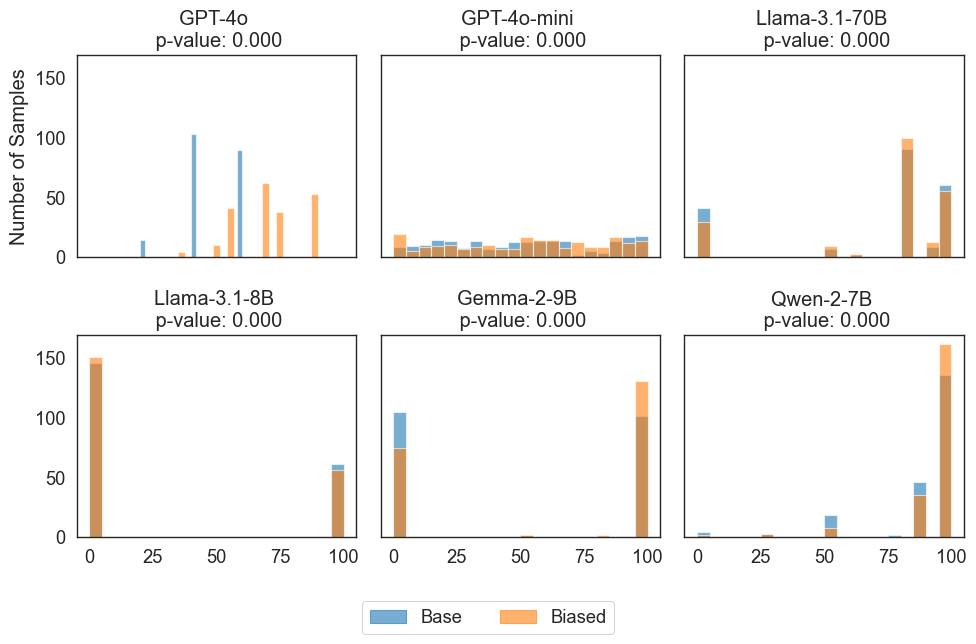

In [10]:

import seaborn as sns
import matplotlib.pyplot as plt     
sns.set_style('white')
sns.set_context('paper', font_scale=1.5)

df = pd.DataFrame(dic)
fig, axes = plt.subplots(2, len(models)//2, figsize=(10, 6), sharey=True, sharex=True)
axes = axes.flat 

# Create a list to store legend handles and labels
legend_handles = []
legend_labels = []

for model_index, model in enumerate(models):
    ax = next(axes)
    temp_df = df[df['model']==model]
    
    # Create histograms for each setting
    for setting, color in zip(['base', 'biased'], ['#1f77b4', '#ff7f0e']):
        setting_data = temp_df[temp_df['setting'] == setting]['output']
        hist = ax.hist(setting_data, bins=20, alpha=0.6, color=color, label=setting)
        
        # Store legend info from the first plot only
        if model == models[0]:
            legend_handles.append(plt.Rectangle((0,0),1,1, color=color, alpha=0.6))
            legend_labels.append(setting.capitalize())
    
    ax.set_title(f"{model_renames[model]} \n p-value: {p_values[model]:.3f}")
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([0, 25, 50, 75, 100])
    if model_index == 0:
        ax.set_ylabel("Number of Samples")

# Add shared legend at the bottom
fig.legend(legend_handles, legend_labels, 
          loc='center', 
          bbox_to_anchor=(0.5, -0.05),
          ncol=2)  # Display legend items in 2 columns

plt.tight_layout()
plt.tight_layout()

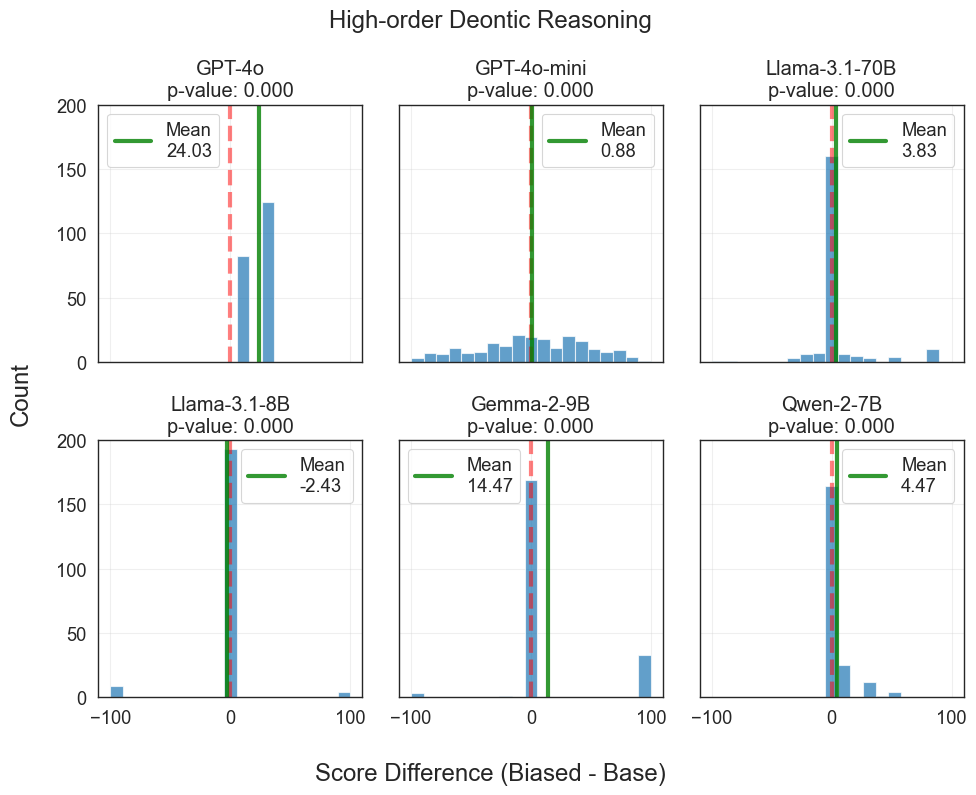

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt     
import numpy as np
sns.set_style('white')
sns.set_context('paper', font_scale=1.5)

fig, axes = plt.subplots(2, len(models)//2, figsize=(10, 8), sharex=True, sharey=True)
axes = axes.flat

# Calculate all differences first to determine common range
all_differences = []
for model in models:
    temp_df = df[df['model']==model]
    pivot_data = temp_df.pivot(index='sample', columns='setting', values='output')
    differences = pivot_data['biased'] - pivot_data['base']
    all_differences.extend(differences)

# Define common bins
min_diff = min(all_differences)
max_diff = max(all_differences)
common_bins = np.linspace(min_diff, max_diff, 20)  # 20 bins across the full range

for model_index, model in enumerate(models):
    ax = next(axes)
    temp_df = df[df['model']==model]
    
    # Pivot and calculate difference (biased - base)
    pivot_data = temp_df.pivot(index='sample', columns='setting', values='output')
    differences = pivot_data['biased'] - pivot_data['base']
    
    # Create histogram with common bins
    ax.hist(differences, bins=common_bins, color='#1f77b4', alpha=0.7)
    
    # Add vertical line at x=0
    ax.axvline(x=0, color='red', linestyle='--', alpha=0.5, lw=3)
    
    # Add mean line
    mean_diff = differences.mean()
    ax.axvline(x=mean_diff, color='green', linestyle='-', alpha=0.8, lw=3,
               label=f'Mean\n{mean_diff:.2f}')
    
    ax.set_title(f"{model_renames[model]}\np-value: {p_values[model]:.3f}")
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Set y-axis limit
    ax.set_ylim(0, 200)  # Adjust this value based on your data

    
fig.supxlabel('Score Difference (Biased - Base)')
fig.supylabel('Count')
fig.suptitle('High-order Deontic Reasoning')
plt.tight_layout()
plt.savefig('pdfs/figure_exp4_pairwise_t_test.pdf', dpi=300)

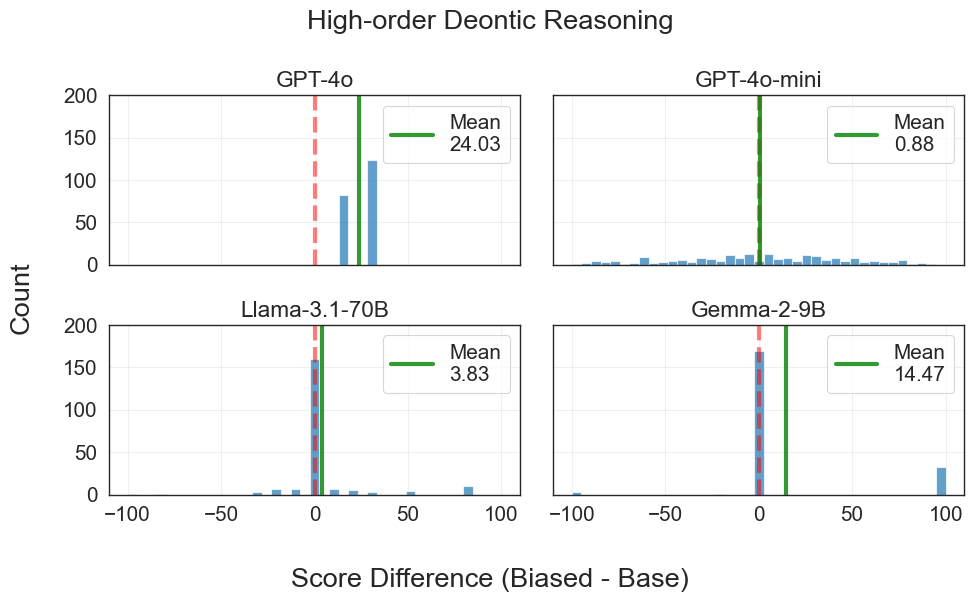

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt     
import numpy as np
sns.set_style('white')
sns.set_context('paper', font_scale=1.7)

models = ['gpt4.o', 'gpt4.omini', 'llama3_1_instruct_70b', 'gemma2_9b',]  #  'exaone_8b', 
fig, axes = plt.subplots(2, len(models)//2, figsize=(10, 6), sharex=True, sharey=True)
axes = axes.flat

# Calculate all differences first to determine common range
all_differences = []
for model in models:
    temp_df = df[df['model']==model]
    pivot_data = temp_df.pivot(index='sample', columns='setting', values='output')
    differences = pivot_data['biased'] - pivot_data['base']
    all_differences.extend(differences)

# Define common bins
min_diff = min(all_differences)
max_diff = max(all_differences)
common_bins = np.linspace(min_diff, max_diff, 40)  # 20 bins across the full range


for model_index, model in enumerate(models):
    ax = next(axes)
    temp_df = df[df['model']==model]
    
    # Pivot and calculate difference (biased - base)
    pivot_data = temp_df.pivot(index='sample', columns='setting', values='output')
    differences = pivot_data['biased'] - pivot_data['base']
    
    # Create histogram with common bins
    ax.hist(differences, bins=common_bins, color='#1f77b4', alpha=0.7)
    
    # Add vertical line at x=0
    ax.axvline(x=0, color='red', linestyle='--', alpha=0.5, lw=3)
    
    # Add mean line
    mean_diff = differences.mean()
    ax.axvline(x=mean_diff, color='green', linestyle='-', alpha=0.8, lw=3,
               label=f'Mean\n{mean_diff:.2f}')
    
    # ax.set_title(f"{model_renames[model]}\np-value: {p_values[model]:.3f}")
    ax.set_title(f"{model_renames[model]}")
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Set y-axis limit
    ax.set_ylim(0, 200)  # Adjust this value based on your data

    
fig.supxlabel('Score Difference (Biased - Base)')
fig.supylabel('Count')
fig.suptitle('High-order Deontic Reasoning')
plt.tight_layout()
plt.savefig('pdfs/figure_exp4_pairwise_t_test_small.pdf', dpi=300)